In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

SAVE_PLOTS = True
STANDARD_DPI = 300

In [2]:
def load_h5_data(filename):
    data = {}
    with h5py.File(filename, 'r') as f:
        for voltage in f.keys():
            data[int(voltage)] = {'CH1': [], 'CH2': []}

            for i in f[voltage]['CH1']:
                arr = np.array(f[voltage]['CH1'][i])  # Load as NumPy array
                df = pd.DataFrame(arr, columns=['t', 'V'])  # Convert to DataFrame
                data[int(voltage)]['CH1'].append(df)

            for i in f[voltage]['CH2']:
                arr = np.array(f[voltage]['CH2'][i])
                df = pd.DataFrame(arr, columns=['t', 'V'])
                data[int(voltage)]['CH2'].append(df)

    return data

In [3]:
noise_data = pd.read_csv('data\dark_pmt\I_V_noise_700_2285V.csv')
noise_data.head(1)

,time,pmt_high_voltage,pmt_current,v_p2p_ch1,v_rms_ch1,v_p2p_ch2,v_rms_ch2
0,1.741440e+09,700.1,67.78,0.04,0.010568,0.0408,0.012731


In [4]:
noise_data['V_set'] = noise_data['pmt_high_voltage'].round(0)

In [5]:
path_to_signals = "data/gain_fixed_light/signals_20250308-173933.h5"
signals = load_h5_data(path_to_signals)
print('available keys:', list(signals.keys()))
print('maximum key:', max(signals.keys()))

available keys: [1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]
maximum key: 1890


In [6]:
signals[1700]['CH1'][0].head(1)

,t,V
0,-0.00049,-0.8


In [7]:

def get_average_p2p(channel_key):
    avg_p2ps = []
    for s in signals.values():
        
        p2ps = [ d['V'].max() - d['V'].min() for d in s[channel_key] ]
        avg_p2ps.append(np.mean(p2ps))
    return avg_p2ps

df = {
    'V': list(signals.keys()),
    'p2p_ch1': get_average_p2p('CH1'),
    'p2p_ch2': get_average_p2p('CH2')
}
df = pd.DataFrame(df)
df.head(1)

,V,p2p_ch1,p2p_ch2
0,1000,0.5344,0.488


In [8]:
# add in all points from the noise data where the voltage is in the signals data
df['noise_ch1_p2p'] = df['V'].apply(lambda v: noise_data[noise_data['V_set'] == v]['v_p2p_ch1'].values[0])
df['noise_ch2_p2p'] = df['V'].apply(lambda v: noise_data[noise_data['V_set'] == v]['v_p2p_ch2'].values[0])

df['noise_ch1_rms'] = df['V'].apply(lambda v: noise_data[noise_data['V_set'] == v]['v_rms_ch1'].values[0])
df['noise_ch2_rms'] = df['V'].apply(lambda v: noise_data[noise_data['V_set'] == v]['v_rms_ch2'].values[0])

df.head(1)


,V,p2p_ch1,p2p_ch2,noise_ch1_p2p,noise_ch2_p2p,noise_ch1_rms,noise_ch2_rms
0,1000,0.5344,0.488,0.0408,0.0408,0.010812,0.01228


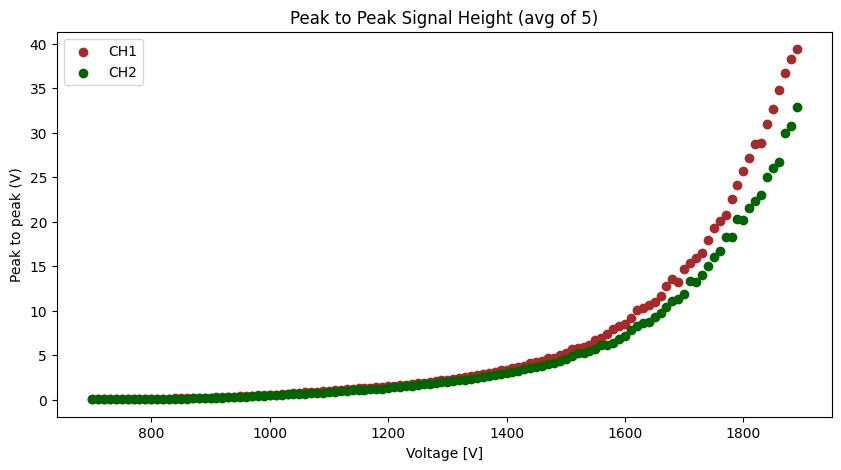

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(df['V'], df['p2p_ch1'], label='CH1', color = 'brown')
ax.scatter(df['V'], df['p2p_ch2'], label='CH2', color = 'darkgreen')
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('Peak to peak (V)')

ax.set_yscale('log')

ax.set_title('Peak to Peak Signal Height (avg of 5)')
ax.legend()

if SAVE_PLOTS:
    plt.savefig('plots/pmt_noise_tests/pmt1/p2p_signal_heights.jpg', dpi=STANDARD_DPI)

plt.show()

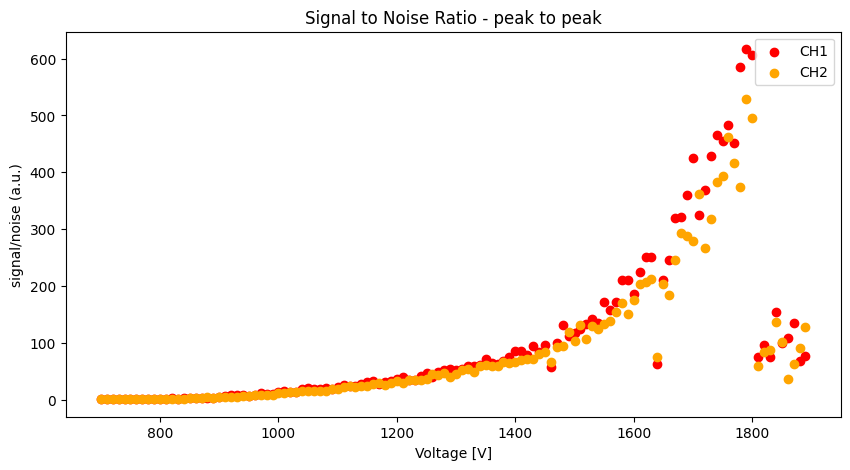

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

df['sig2noise_ch1'] = df['p2p_ch1'] / df['noise_ch1_p2p']
df['sig2noise_ch2'] = df['p2p_ch2'] / df['noise_ch2_p2p']

ax.scatter(df['V'], df['sig2noise_ch1'], label='CH1', color = 'red')
ax.scatter(df['V'], df['sig2noise_ch2'], label='CH2', color = 'orange')
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('signal/noise (a.u.)')
ax.set_title('Signal to Noise Ratio - peak to peak')
ax.legend()

if SAVE_PLOTS:
    plt.savefig('plots/pmt_noise_tests/pmt1/signal_to_noise_p2p.jpg', dpi=STANDARD_DPI)

plt.show()

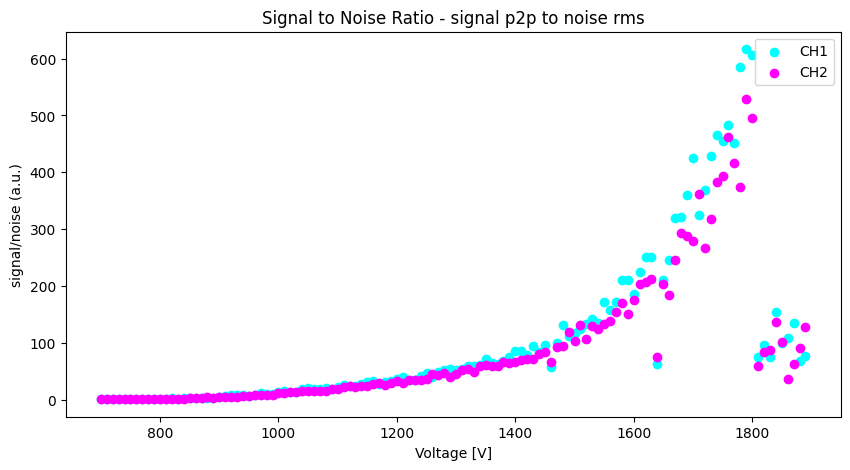

In [11]:

fig, ax = plt.subplots(figsize=(10, 5))

df['sig2noise_ch1'] = df['p2p_ch1'] / df['noise_ch1_p2p']
df['sig2noise_ch2'] = df['p2p_ch2'] / df['noise_ch2_p2p']

ax.scatter(df['V'], df['sig2noise_ch1'], label='CH1', color = 'cyan')
ax.scatter(df['V'], df['sig2noise_ch2'], label='CH2', color = 'magenta')
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('signal/noise (a.u.)')
ax.set_title('Signal to Noise Ratio - signal p2p to noise rms')
ax.legend()

if SAVE_PLOTS:
    plt.savefig('plots/pmt_noise_tests/pmt1/signal_to_noise_ratio_rms.jpg', dpi=STANDARD_DPI)

plt.show()